In [ ]:
# I, Katie Mowry, No copies of the AWS crendentials file is stored on any publicly accessible location, 
# nor is the file in any way shared with anyone outside of DATA_ENG 300 (Spring 2025).

In [1]:
!curl https://certs.secureserver.net/repository/sf-class2-root.crt -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1468  100  1468    0     0   6141      0 --:--:-- --:--:-- --:--:--  6168


In [3]:
%pip install cassandra-sigv4

Note: you may need to restart the kernel to use updated packages.


In [6]:
from cassandra.cluster import Cluster
from ssl import SSLContext, PROTOCOL_TLSv1_2, CERT_REQUIRED
from cassandra_sigv4.auth import SigV4AuthProvider
import boto3

# ssl setup
ssl_context = SSLContext(PROTOCOL_TLSv1_2)
ssl_context.load_verify_locations('sf-class2-root.crt')  # change your file path for locating the certificate
ssl_context.verify_mode = CERT_REQUIRED

# boto3 session setup
boto_session = boto3.Session(region_name="us-east-2")  # this AWS credentials is specific to `us-east-2` region

/tmp/ipykernel_119/332746716.py:7: DeprecationWarning: ssl.PROTOCOL_TLSv1_2 is deprecated
  ssl_context = SSLContext(PROTOCOL_TLSv1_2)


In [7]:
# authorization setup with SigV4
auth_provider = SigV4AuthProvider(boto_session)

In [8]:
# authorization setup with SigV4
auth_provider = SigV4AuthProvider(boto_session)
#cluster setup 
cluster = Cluster(['cassandra.us-east-2.amazonaws.com'], 
                  ssl_context=ssl_context, 
                  auth_provider=auth_provider, 
                  port=9142)  # TLS only communicates on port 9142

In [9]:
# establishing connection to Keyspace
session = cluster.connect()

In [10]:
# Creating a keyspace for HW2
r = session.execute('''
    CREATE KEYSPACE IF NOT EXISTS de300_homework2 
    WITH replication = {'class': 'SingleRegionStrategy'};
    ''')
print(r.current_rows)

[]


In [11]:
r = session.execute('''
    SELECT * FROM system_schema.keyspaces;
    ''')
print(r.current_rows) 

[Row(keyspace_name='system_schema', durable_writes=True, replication=OrderedMapSerializedKey([('class', 'org.apache.cassandra.locator.SimpleStrategy'), ('replication_factor', '3')])), Row(keyspace_name='system_schema_mcs', durable_writes=True, replication=OrderedMapSerializedKey([('class', 'org.apache.cassandra.locator.SimpleStrategy'), ('replication_factor', '3')])), Row(keyspace_name='system', durable_writes=True, replication=OrderedMapSerializedKey([('class', 'org.apache.cassandra.locator.SimpleStrategy'), ('replication_factor', '3')])), Row(keyspace_name='system_multiregion_info', durable_writes=True, replication=OrderedMapSerializedKey([('class', 'org.apache.cassandra.locator.SimpleStrategy'), ('replication_factor', '3')])), Row(keyspace_name='aet7207_hw2', durable_writes=True, replication=OrderedMapSerializedKey([('class', 'org.apache.cassandra.locator.SimpleStrategy'), ('replication_factor', '3')])), Row(keyspace_name='aye8078_hw2', durable_writes=True, replication=OrderedMapSer

In [49]:
from cassandra.cluster import ExecutionProfile, EXEC_PROFILE_DEFAULT
from cassandra import ConsistencyLevel


# Define execution profile with LOCAL_QUORUM
execution_profile = ExecutionProfile(
    consistency_level=ConsistencyLevel.LOCAL_QUORUM
)

# Cluster setup with correct profile
cluster = Cluster(
    ['cassandra.us-east-2.amazonaws.com'],
    ssl_context=ssl_context,
    auth_provider=auth_provider,
    port=9142,
    execution_profiles={EXEC_PROFILE_DEFAULT: execution_profile}
)

# establishing connection to Keyspace
session = cluster.connect()
session.set_keyspace('de300_homework2') 

In [35]:
import pandas as pd
df_usage = pd.read_csv('drug_usage_raw.csv')

In [28]:
import uuid

session.execute("""
CREATE TABLE IF NOT EXISTS drug_types_2 (
        ethnicity text,
        drug_type text,
        insert_id uuid,
        PRIMARY KEY ((ethnicity, drug_type), insert_id))
""")

In [29]:
from cassandra.query import SimpleStatement

for row in df_usage.itertuples(index=False):
    session.execute("""
        INSERT INTO drug_types_2 (ethnicity, drug_type, insert_id)
        VALUES (%s, %s, %s)
    """, (row.ethnicity, row.drug_type, uuid.uuid4()))

In [32]:
rows = session.execute("SELECT ethnicity, drug_type FROM drug_types_2")
df_cassandra = pd.DataFrame(rows)

df_summary = df_cassandra.groupby(['ethnicity', 'drug_type']).size().reset_index(name='drug_amount')

top_drugs = (df_summary.sort_values(['ethnicity', 'drug_amount'], ascending=[True, False])
    .groupby('ethnicity')
    .head(1)
    .sort_values('drug_amount', ascending=False)
    .reset_index(drop=True)
)

print(top_drugs)

                                           ethnicity drug_type  drug_amount
0                                              WHITE      MAIN         5420
1                     HISPANIC/LATINO - PUERTO RICAN      MAIN          860
2                             BLACK/AFRICAN AMERICAN      MAIN          476
3                              UNKNOWN/NOT SPECIFIED      MAIN          245
4                                 HISPANIC OR LATINO      MAIN          226
5  AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...      MAIN          200
6                                              ASIAN      MAIN          121
7                                   UNABLE TO OBTAIN      MAIN           89
8                                              OTHER      MAIN           72


In [38]:
age_groups = pd.read_csv("df_age_groups_nosql.csv")
age_groups.head()

,short_title,age
0,PTCA,300
1,Transplant cadaver donor,44
2,Other brain dx procedure,20
3,Adm inhal nitric oxide,44
4,Inject/infus nesiritide,44


In [ ]:
# Question 2

In [39]:
session.execute("""
CREATE TABLE IF NOT EXISTS age_groups_2 (
    age int,
    short_title text,
    insert_id uuid,
    PRIMARY KEY ((age, short_title), insert_id)
)
""")

In [40]:
for row in age_groups.itertuples(index=False):
    session.execute("""
        INSERT INTO age_groups_2 (age, short_title, insert_id)
        VALUES (%s, %s, %s)
    """, (row.age, row.short_title, uuid.uuid4()))

In [41]:
rows = session.execute("SELECT age, short_title FROM age_groups_2")
age_groups_2_df = pd.DataFrame(rows)

In [43]:
def assign_age_group(age):
    if age <= 19:
        return '0–19'
    elif age <= 49:
        return '20–49'
    elif age <= 79:
        return '50–79'
    else:
        return '>80'

# Assigning the age groups
age_groups_2_df["age_group"] = age_groups_2_df["age"].apply(assign_age_group)

summary = age_groups_2_df.groupby(["age_group", "short_title"]).size().reset_index(name="procedure_count")

top3_procedures = (
    summary.sort_values(["age_group", "procedure_count"], ascending=[True, False])
    .groupby("age_group")
    .head(3)
    .reset_index(drop=True)
)
print(top3_procedures)


   age_group               short_title  procedure_count
0       0–19           Venous cath NEC                2
1       0–19  Applic ext fix dev-femur                1
2       0–19         Atlas-axis fusion                1
3      20–49           Venous cath NEC                9
4      20–49   Entral infus nutrit sub                7
5      20–49  Cont inv mec ven 96+ hrs                6
6      50–79           Venous cath NEC               25
7      50–79   Entral infus nutrit sub               22
8      50–79   Packed cell transfusion               13
9        >80           Venous cath NEC               20
10       >80   Packed cell transfusion               13
11       >80  Insert endotracheal tube                8


In [50]:
ICU_stays = pd.read_csv("ICU_stay_nosql.csv")

In [51]:
session.execute("""
CREATE TABLE IF NOT EXISTS icu_stays_2 (
    gender text,
    ethnicity text,
    icu_length_of_stay float,
    insert_id uuid,
    PRIMARY KEY ((gender, ethnicity), insert_id)
)
""")

In [52]:
for row in ICU_stays.itertuples(index=False):
    session.execute("""
    INSERT INTO icu_stays_2 (gender, ethnicity, icu_length_of_stay, insert_id)
    VALUES (%s, %s, %s, %s)
    """, (row.gender, row.ethnicity, row.icu_length_of_stay, uuid.uuid4()))

In [53]:
rows = session.execute("SELECT gender, ethnicity, icu_length_of_stay FROM icu_stays_2")
df_cassandra = pd.DataFrame(rows)

In [57]:
print(df_cassandra.groupby("gender")["icu_length_of_stay"].agg(["mean", "std", "median"]))
print(df_cassandra.groupby("ethnicity")["icu_length_of_stay"].agg(["mean", "std", "median"]))

            mean       std  median
gender                            
F       5.540635  7.818025    2.41
M       3.513973  4.176268    1.93
                                                         mean        std  \
ethnicity                                                                  
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNI...  11.335000  14.248202   
ASIAN                                                3.890000   4.567910   
BLACK/AFRICAN AMERICAN                               7.675714  10.920249   
HISPANIC OR LATINO                                   7.463333   6.579912   
HISPANIC/LATINO - PUERTO RICAN                       3.244000   3.259647   
OTHER                                                0.926667   0.911501   
UNABLE TO OBTAIN                                    13.360000        NaN   
UNKNOWN/NOT SPECIFIED                                4.924546   4.820200   
WHITE                                                4.130870   6.139099   

                       

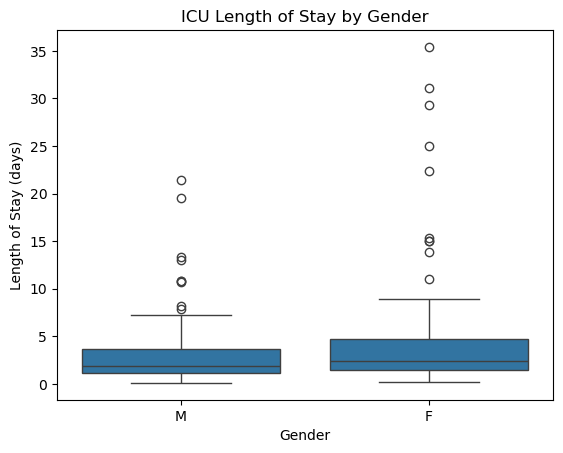

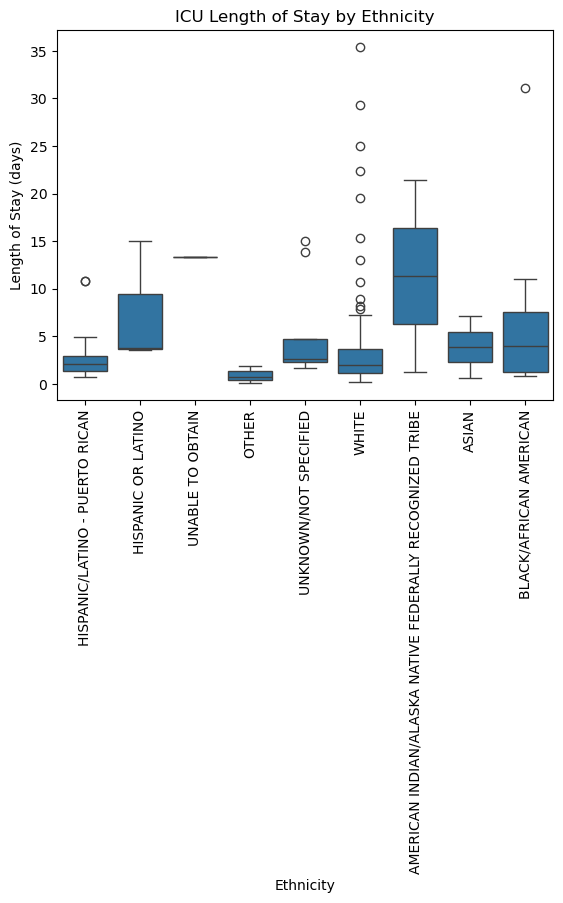

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_cassandra, x="gender", y="icu_length_of_stay")
plt.title("ICU Length of Stay by Gender")
plt.ylabel("Length of Stay (days)")
plt.xlabel("Gender")
plt.show()

sns.boxplot(data=df_cassandra, x="ethnicity", y="icu_length_of_stay")
plt.xticks(rotation=90)
plt.title("ICU Length of Stay by Ethnicity")
plt.ylabel("Length of Stay (days)")
plt.xlabel("Ethnicity")
plt.show()